# Technical Appendix

## 1. Import Necessay Libraries

Note: Please make sure the installed scikit-learn version is 1.2.2

Otherwise there will be conflicts between packagaes and the importing code block won't work

To do so, you can type following commands in the Anaconda Prompt:
*  _pip uninstall scikit-learn_
*  _pip install scikit-learn==1.2.2_

In [1]:
# Import necessary libraries 
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

## 2. Data Exploration

### 2.1 Dataset Overview

In [2]:
# Import data
df = pd.read_csv("BankChurners.csv", usecols=list(range(0,21)))
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### 2.2 Check Distribution of Target Feature:  Attrition_Flag

Text(0.5, 0, 'Attrition_Flag')

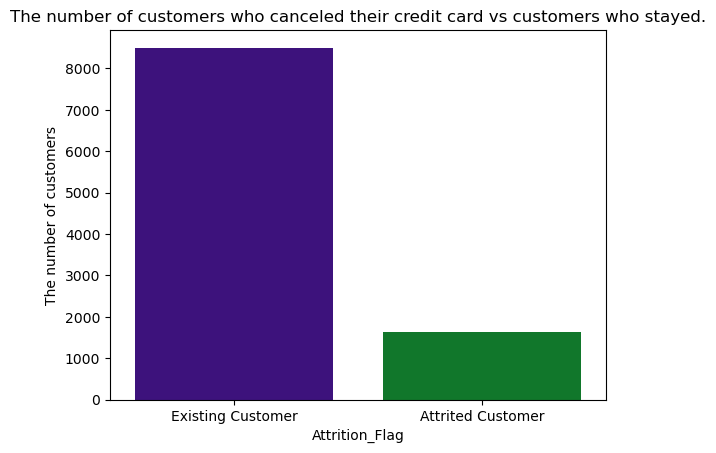

In [3]:
colors = ['#39008E', '#008823']
sns.set_palette(sns.color_palette(colors))
sns.countplot(x="Attrition_Flag", data=df)
plt.title("The number of customers who canceled their credit card vs customers who stayed.")
plt.ylabel("The number of customers")
plt.xlabel("Attrition_Flag")

From the bar chart above, we can see that the existing customers are over 8000, but the attrited customers are only around 2000. 

It increases the difficulty for training our model to predict churning customers because of the imbalanced data.

### 2.3 Check categorical attribute

In [4]:
# Print the categories for each categorical attribute
pd.set_option('display.max_colwidth', 0)
cat = []
for col_name in df.select_dtypes(include=['object']).columns:
    categories_list = df[col_name].value_counts().index.to_list()
    cat.append([col_name, categories_list])
pd.DataFrame(cat, columns=["Column Name", "Classes"]).set_index("Column Name").rename_axis(None)

,Classes
Attrition_Flag,"[Existing Customer, Attrited Customer]"
Gender,"[F, M]"
Education_Level,"[Graduate, High School, Unknown, Uneducated, College, Post-Graduate, Doctorate]"
Marital_Status,"[Married, Single, Unknown, Divorced]"
Income_Category,"[Less than $40K, $40K - $60K, $80K - $120K, $60K - $80K, Unknown, $120K +]"
Card_Category,"[Blue, Silver, Gold, Platinum]"


## 3. Data Preprocessing

### 3.1 Check Missing values

In [5]:
missing_values = []
columns = df.columns.to_list()
for column in columns:
    null_values = df[column].isnull().sum()
    missing_values.append([column, null_values])
pd.DataFrame(missing_values, columns=["Column Name", "Number of missing values"]).set_index("Column Name").rename_axis(None)

,Number of missing values
CLIENTNUM,0
Attrition_Flag,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0


No missing value found, so we do not need to worry about handling missing data

### 3.2 Check 'unknown' variables

In [6]:
print("'Uknown' observations: {} out of {}".format((df[(df["Education_Level"] == "Unknown") | 
   (df["Marital_Status"] == "Unknown") | 
   (df["Income_Category"] == "Unknown")].shape[0]), df.shape[0]))

'Uknown' observations: 3046 out of 10127


There are 3046 'Unknown' values existing in our dataset.

Rather than removing it, it is important to retain this category, as it can contain a significant amount of information that can be useful in analysis. 

When encoding the categorical variable that contains 'Unknown' category, we labeled "Unknown" category as 0 in the ordinal encoder, which means it will be the first numbered category

This approach allows the information contained in the "Unknown" category to be preserved while allowing easier numerical analysis of the data.

### 3.3 Encode categorical features

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Defining the encoding variables
ordinal_enc_variables = ["Education_Level", "Income_Category", "Card_Category"]
one_hot_enc_variables = ["Gender", "Marital_Status"]

# Defining ordinal categories
edu_lvl = ["Unknown", "Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
income_cat = ["Unknown", "Less than $40K", "$40K - $60K", "$80K - $120K", "$60K - $80K", "$120K +"]
card_cat = ["Blue", "Silver", "Gold", "Platinum"]

# Create a copy of the original dataframe
df_encoded = df.copy()

# Encode ordinal variables
ord_enc = OrdinalEncoder(categories=[edu_lvl, income_cat, card_cat])
df_encoded[ordinal_enc_variables] = ord_enc.fit_transform(df_encoded[ordinal_enc_variables])

# Encode one-hot variables
one_hot_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
one_hot_enc_df = pd.DataFrame(one_hot_enc.fit_transform(df_encoded[one_hot_enc_variables]))
one_hot_enc_df.columns = one_hot_enc.get_feature_names_out(one_hot_enc_variables)
df_encoded = pd.concat([df_encoded.drop(one_hot_enc_variables, axis=1), one_hot_enc_df], axis=1)



### 3.4 Data Split to Train and Test Sets

In [8]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X = df_encoded.drop(["Attrition_Flag","CLIENTNUM"], axis=1)
y = df_encoded["Attrition_Flag"]
y.replace(to_replace=["Existing Customer", "Attrited Customer"], value=[0, 1], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print training dataset
X_train.columns

Index(['Customer_Age', 'Dependent_count', 'Education_Level', 'Income_Category',
       'Card_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio', 'Gender_F', 'Gender_M',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown'],
      dtype='object')

## 4. Model Training and Selection

In [15]:
%%capture
# Define the models to be tested
models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier()}

# Define the resampling techniques to be tested
resamplers = {'SMOTE': SMOTE(),
              'Random Under Sampling': RandomUnderSampler(),
              'Random Over Sampling': RandomOverSampler()}

results = []
# Iterate over each model
# Note: It may take several minutes to run it
for model_name, model in models.items():
    
    # Iterate over each resampling technique
    for resampler_name, resampler in resamplers.items():
        
        # Resample the training data
        X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
        
        # Apply feature selection with RFECV
        selector = RFECV(model, step=1, min_features_to_select=5, cv=10)
        selector.fit(X_train_resampled, y_train_resampled)
        X_train_selected = selector.transform(X_train_resampled)
        
        # Fit the model on the selected features
        pipeline = make_imb_pipeline(StandardScaler(), model)
        pipeline.fit(X_train_selected, y_train_resampled)
        
        # Evaluate the model on the test set
        X_test_selected = selector.transform(X_test)
        y_pred = pipeline.predict(X_test_selected)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        # Append the results to the list
        results.append({'Model': model_name,
                        'Resampling Technique': resampler_name,
                        'Accuracy': acc,
                        'Precision': precision,
                        'Recall': recall,
                        'F1 Score': f1})

# Convert the results to a dataframe
results_df = pd.DataFrame(results)

In [16]:
results_df

,Model,Resampling Technique,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,SMOTE,0.849951,0.525707,0.824597,0.642072
1,Logistic Regression,Random Under Sampling,0.845673,0.516729,0.840726,0.640061
2,Logistic Regression,Random Over Sampling,0.840408,0.506667,0.842742,0.632854
3,Decision Tree,SMOTE,0.920369,0.715254,0.850806,0.777164
4,Decision Tree,Random Under Sampling,0.884172,0.596774,0.895161,0.716129
5,Decision Tree,Random Over Sampling,0.932873,0.810638,0.768145,0.788820
6,Random Forest,SMOTE,0.955577,0.864646,0.862903,0.863774
7,Random Forest,Random Under Sampling,0.929582,0.712991,0.951613,0.815199
8,Random Forest,Random Over Sampling,0.958868,0.900648,0.840726,0.869656


The table above shows the performance of different classification models using different resampling techniques. The models were evaluated in terms of accuracy, F1 score, precision, and recall. The best model is:

**Random Forest with Over Sampling:** This model obtained the best performance in terms of detecting false positives with an **accuracy of 0.959** and a **precision of 0.901**.

However, we will continue to search for optimal performance. We will now focus on hyperparameter optimization to further refine these models. I will explore different combinations of hyperparameters using techniques such as cross-validation and randomized search to find the best set of hyperparameters.

## 5. Model Optimization - Hyperparameter Tuning

Hyperparameters are parameters that must be set before training the model, such as the number of estimators in a random forest or the maximum depth of a decision tree.

The Random Forest hyperparameters are considered as follows:
* The number of estimators in the set (n_estimators).
* The number of variables to consider for each node split (max_features).
* The maximum depth number (max_depth).
* The minimum number of observations required to split a node (min_samples_split).
* The minimum number of observations required to be a leaf (min_samples_leaf).

Hyperparameter optimization of Random Forest can be done using a grid search method. By finding the best hyperparameters, we can improve the performance of the model.

### 5.1 Randomized Search

Randomized search is a method for searching for the best hyperparameters of a machine learning model.

Rather than testing all possible combinations of hyperparameters, which can be very computationally expensive, random search performs a random selection of combinations. We can specify a probability distribution for each hyperparameter, and the random search will randomly draw values from these distributions. We then train the model with each combination of hyperparameters and evaluate its performance.

Random search makes it possible to find efficient combinations of hyperparameters faster than exhaustive search. It can be used in conjunction with cross-validation to estimate model performance more robustly.

In [17]:
# Random Forest with Random Over Sampling
resampler = RandomOverSampler()
model = RandomForestClassifier()
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)
selector = RFECV(model, step=1, min_features_to_select=5, cv=10)
selector.fit(X_train_resampled, y_train_resampled)
X_train_selected = selector.transform(X_train_resampled)
X_test_selected = selector.transform(X_test)

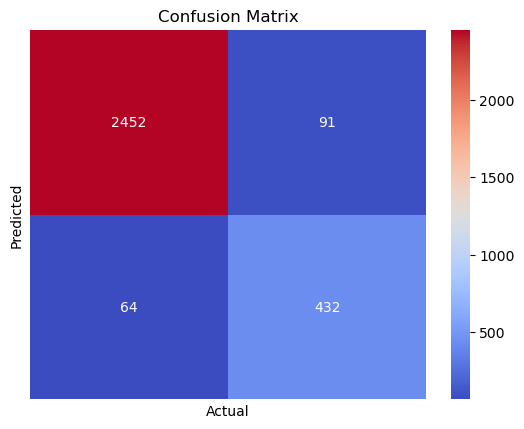

,Accuracy,Precision,Recall,F1
0,0.962375,0.923544,0.841263,0.868794


In [19]:
# Define the model and hyperparameters to search over
rf = RandomForestClassifier()
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2,3,4,5,6,7],
    'min_samples_leaf': [1,2,3,4,5,6]
}

# Perform randomized search
search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, scoring='recall', n_jobs=-1, cv=4, random_state=1)
search.fit(X_train_selected , y_train_resampled)

# Make predictions on test set
y_pred = search.best_estimator_.predict(X_test_selected)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g',cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics and create dataframe
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
metrics_df = pd.DataFrame({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, index=[0])
metrics_df

For Random Forest with random oversampling (ROS) technique:

Before randomized search for hyperparameters:
* Accuracy is 0.959
* Precision is 0.901
* Recall is 0.841
* F1 score is 0.870

After randomized search for hyperparameters:
* Accuracy is 0.962
* Precision is 0.924
* Recall is 0.841
* F1 score is 0.869

Comparing the results before and after randomized search, we can see that:
* Recall and F1 score remained approximately the same
* But accuracy and precision increased slightly after randomized search. 

This suggests that the randomized search of hyperparameters helped optimize the models and improve their performance.

In [20]:
print(search.best_params_)

{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


In [21]:
# Tuned RandomOverSampling Model
model1 = RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=30)
ROS = RandomOverSampler()
X_train_resampled, y_train_resampled = ROS.fit_resample(X_train, y_train) 
model1.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=30, n_estimators=50)

## 6. Evaluation

### 6.1 Computed Performance Metrics

Recall that we have following perforamce metrics calculated:
* Accuracy is 0.962
* Precision is 0.924
* Recall is 0.841
* F1 score is 0.869

### 6.2 ROC Curve

ROC curve is a useful tool for evaluating the performance of a binary classification model and for determining the best classification threshold to optimize the model's performance.

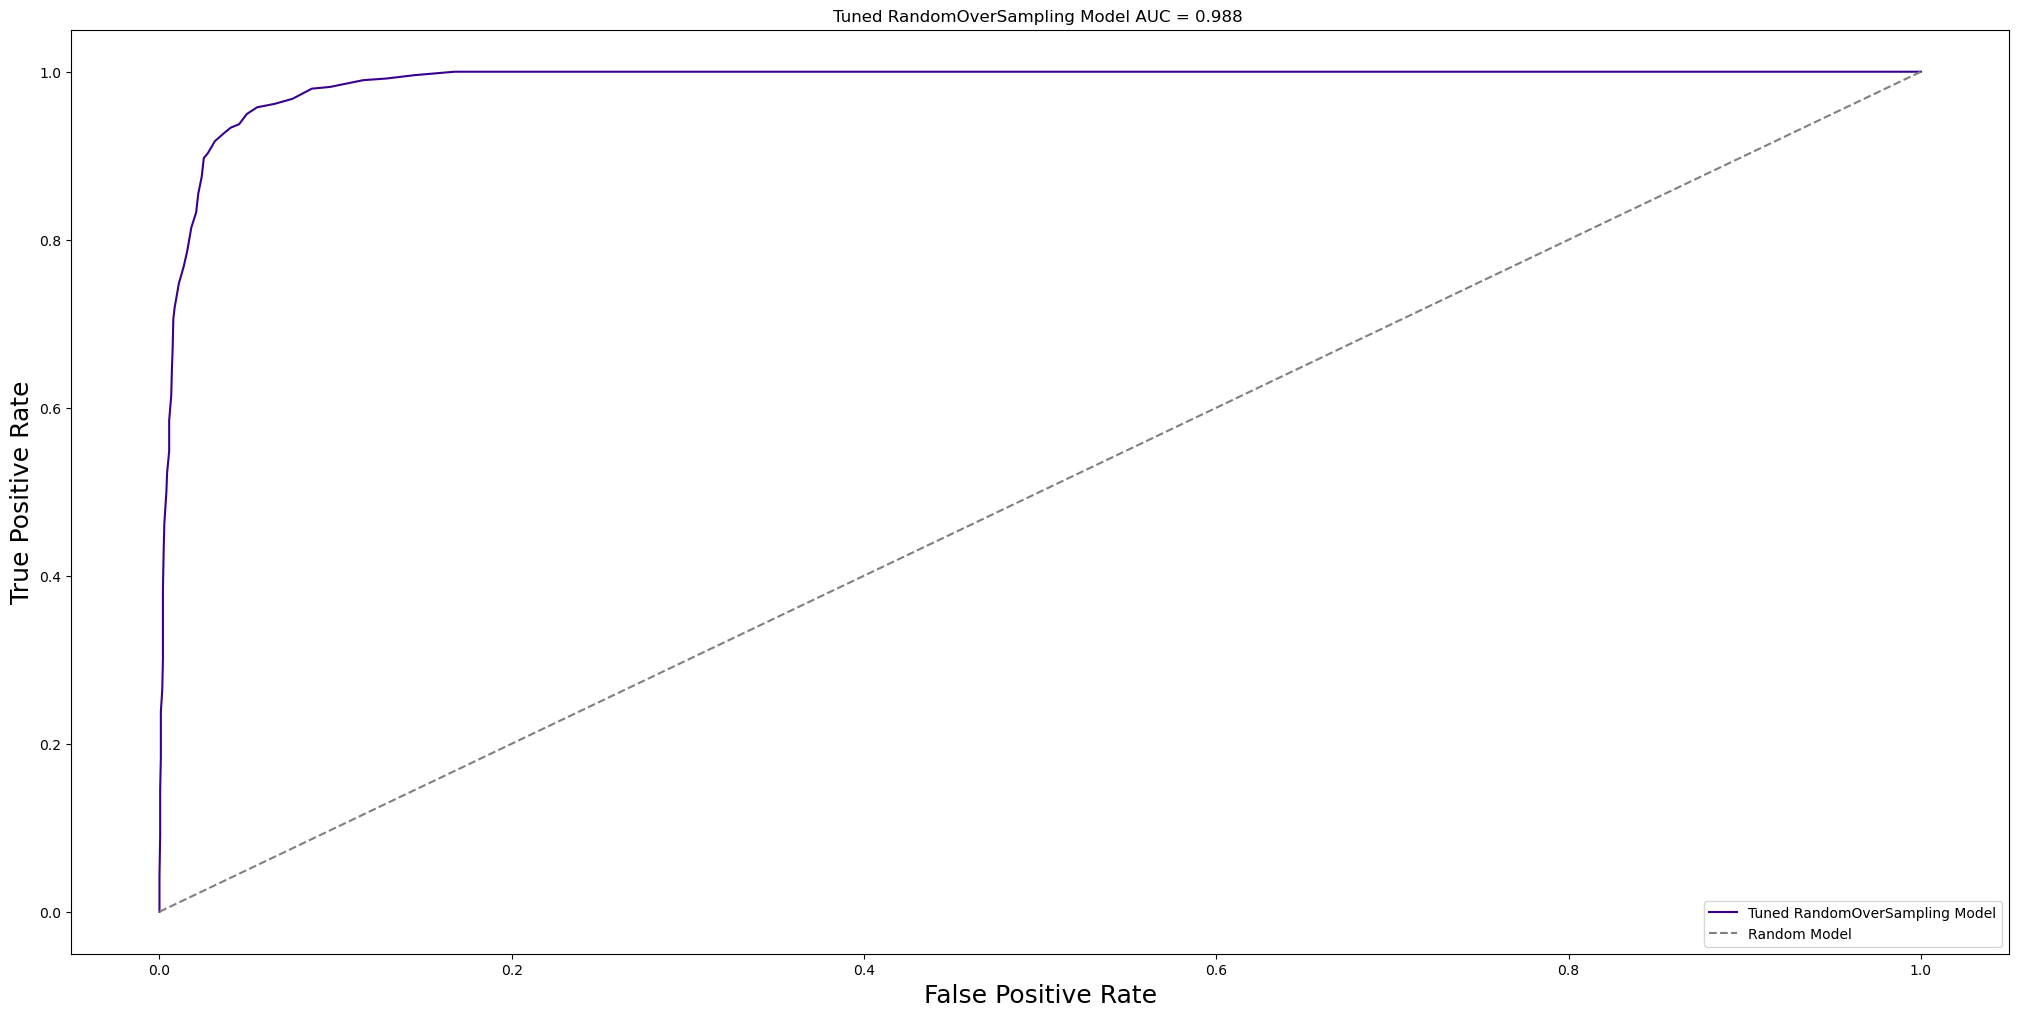

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict using tuned RandomOverSampling model
y_pred1 = model1.predict_proba(X_test)[:,1]
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)

# Calculate AUC score
auc1 = roc_auc_score(y_test, y_pred1)

# Plot ROC curves 
plt.figure(figsize=(25, 12))
plt.plot(fpr1, tpr1, label='Tuned RandomOverSampling Model')

# Add diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend()
plt.title(f'Tuned RandomOverSampling Model AUC = {auc1:.3f} ')
plt.show()

The ROC curve showed that the performance with an AUC is 0.989 which is close to 1.0, and indicated a very good ability to discriminate between positive and negative classes.

### 6.3 Evaluation Summary

In summary, the following performance metrics were evaluated:
* AUC: 0.988
* Accuracy is 0.962
* Precision is 0.924
* Recall is 0.841
* F1 score is 0.869

This suggest that the model, **Random Forest with Random Over Sampling technique**, is good at classifying imbalanced data from the bank churn dataset.